# Extracting structural features from Winning Tickets

This notebook has the following parts:
* Prerequisites
* Extracting conv1 weight matrices from model 
* Extracting structural features from matrices
* Extracting structural features from Isables Winning Tickets
* Implementing structural features at initialization

## Prerequisites:

In [1]:
# import necessary libraries

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
def load_and_prep_cifar(batch_size, shuffle_size):
    # load data set
    (train_ds, test_ds), ds_info = tfds.load(name="cifar10", split=["train","test"], as_supervised=True, with_info=True)
    # tfds.show_examples(train_ds, ds_info)
    
    def prepare_cifar10_data(ds):
        #convert data from uint8 to float32
        ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
        #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
        ds = ds.map(lambda img, target: ((img/128.)-1., target))
        #create one-hot targets
        ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
        #cache this progress in memory, as there is no need to redo it; it is deterministic after all
        ds = ds.cache()
        #shuffle, batch, prefetch
        ds = ds.shuffle(shuffle_size).batch(batch_size).prefetch(2)
        #return preprocessed dataset
        return ds
    
    # prepare data
    train_dataset = train_ds.apply(prepare_cifar10_data)
    test_dataset = test_ds.apply(prepare_cifar10_data)
    
    return train_dataset, test_dataset

In [3]:
# create the model

class CNN2Model(tf.keras.Model):
    
    # basic
    def __init__(self):
        super(CNN2Model, self).__init__()
        
        # set biases to a value that is not exactly 0.0, so they don't get handled like pruned values
        self.bias_in = tf.keras.initializers.Constant(value=0.0000000001)
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation="relu", padding="same",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batchsize,32,32,64]
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),input_shape=(32, 32, 64)) # [batchsize,16,16,64]
        self.flatten = tf.keras.layers.Flatten() # [batch_size,16384]
        self.dense1 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense2 = tf.keras.layers.Dense(256, activation="relu",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]
        self.dense3 = tf.keras.layers.Dense(10, activation="softmax",kernel_initializer='glorot_uniform', bias_initializer=self.bias_in) # [batch_size,256]

    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
            
    
    def get_conv_weights(self):
        return self.conv1.get_weights(), self.conv2.get_weights(), self.dense3.get_weights()
        
    def set_conv_weights(self,weights_conv1, weights_conv2, weights_dense3):
        self.conv1.set_weights(weights_conv1)
        self.conv2.set_weights(weights_conv2)
        self.dense3.set_weights(weights_dense3)
        
    def get_dense_weights(self):
        return self.dense1.get_weights(), self.dense2.get_weights()
        
    def set_dense_weights(self,weights_dense1, weights_dense2):
        self.dense1.set_weights(weights_dense1)
        self.dense2.set_weights(weights_dense2)

## Extracting conv1 weight matrices from model

In [4]:
# function to extract weight matrix of conv1 layer in practical format

def get_conv1_weights(model):
    # get kernels of the conv1 layer in a neet numpy array and extract pruning rate
    conv1_weights = model.get_conv_weights()[0][0]  # shape=[3,3,3,64]
    conv1_weights_t = np.transpose(conv1_weights, (3, 0, 1, 2)) # shape=[64,3,3,3]
    return conv1_weights_t

In [5]:
# function to load and collect the conv1 kernels of multiple networks in one numpy array

def get_and_load_conv1_weights(files):
    # initialize a model
    train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
    model = CNN2Model()
    model(list(train_dataset)[0][0])
    # load isabels stored weights into model and extract numpy weight matrix of conv1 layer
    all_kernels = None
    first_set = True
    for file in files:
        model.load_weights(file)
        conv1_weights = get_conv1_weights(model)
        # concatenate kernels of each model
        if first_set:
            all_kernels = conv1_weights
            first_set = False
        else:
            all_kernels = np.concatenate((all_kernels,conv1_weights), axis=0)
    return all_kernels

## Extracting structural features from matrices

In [6]:
# calculate the pruning rate (the ratio of non-zero elements) of a weight matrix 
# (or multiple weight matrices collectively)
def get_pruning_rate(weights):
    int_weights = []
    for w in weights:
        int_weights.extend(w.astype(bool).astype(int).flatten())
    pruning_rate = np.mean(int_weights)
    print(f"The pruning rate is {pruning_rate}, so {1 - pruning_rate} of the weights have been set to zero.")
    return pruning_rate

In [7]:
# calculate the positional probabilities of unpruned weights in a kernel
def get_pos_probs(kernels):
    pos_probs = np.mean(kernels.astype(bool).astype(int), axis=0)
    print("The probabilites for each position in the kernel to be unpruned: \n",pos_probs)
    return pos_probs

# extract distribution of signs
def get_sign_ratio(kernels):
    pos_values = len(kernels.flatten()[kernels.flatten()>0.0])
    neg_values = len(kernels.flatten()[kernels.flatten()<0.0])
    ratio = pos_values/neg_values
    print(f"There are {pos_values} positive weights and {neg_values} negative weights. Therfore the sign ratio is {ratio}.")
    return ratio

# extract distribution of number of weights per kernel
def get_weight_distr(kernels):
    # for each kernel, count the number of unpruned weights
    distribution = [0]*(3*3*3+1)
    numbers = range(3*3*3+1)
    for kernel in kernels:
        number_weights = np.sum(kernel.astype(bool).astype(int))
        distribution[number_weights] = distribution[number_weights] + 1
    # turn the distribution into probability distributioin
    distribution = distribution / np.sum(distribution)
    # plot distribution
    plt.bar(numbers,distribution)
    plt.xlabel('number of unpruned weights per kernel')  
    plt.ylabel('probability')  
    plt.title('probability distribution of pruning rate over kernels')  
    plt.show()
    return distribution

## Extracting structural features from Isables Winning Tickets

Right now using all winning tickets form Isabel, probabbly including those that were not succesfull.

In [8]:
# a list of the names of the winning ticket files from Isabels GitHub
def wt_file_names(numbers=5):
    names = []
    for n in range(numbers):
        names.append(f"isabels_wts/WT_s0.1_nr{n}.h5")
    return names

The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.2890625  0.30234375 0.3       ]
  [0.309375   0.2875     0.31875   ]
  [0.30859375 0.31875    0.346875  ]]

 [[0.315625   0.31328125 0.3609375 ]
  [0.296875   0.31640625 0.32109375]
  [0.315625   0.33125    0.3453125 ]]

 [[0.278125   0.28671875 0.32734375]
  [0.32578125 0.3109375  0.321875  ]
  [0.2921875  0.31015625 0.31796875]]]
There are 7037 positive weights and 3803 negative weights. Therfore the sign ratio is 1.8503812779384696.


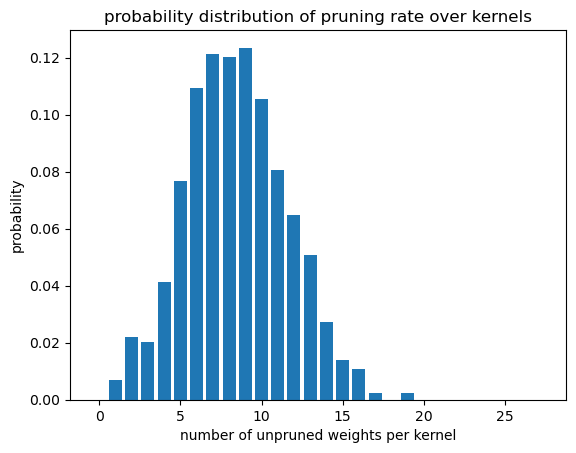

In [9]:
# Extracting structural features form Isables generated winning tickets

file_names = wt_file_names(20)
wt_kernels = get_and_load_conv1_weights(file_names)
wt_pruning_rate = get_pruning_rate(wt_kernels)
wt_pos_probs = get_pos_probs(wt_kernels)
wt_sign_ratio = get_sign_ratio(wt_kernels)
wt_weight_distr = get_weight_distr(wt_kernels)

## Implementing structural features at initialization

In [10]:
# implement random pruning of a weight matrix according to a pruning rate
def random_pruning(kernels, pruning_rate):
    shape = np.shape(kernels)
    kernels = kernels.flatten()
    # caclulate how many weights need to be pruned
    pruning_number = int((1-pruning_rate) * len(kernels))
    # choose accordingly a random selection of weights to get pruned
    pruning_indexi = random.sample(range(len(kernels)),pruning_number)
    kernels[pruning_indexi] = 0.0
    kernels = np.reshape(kernels,shape)
    return kernels

# adapt signs in a weight matrix such that it fullfills a certain sign ratio
def sign_ratio_adaption(kernels, sign_ratio):
    shape = np.shape(kernels)
    kernels = np.abs(kernels.flatten())
    # get indexi of all unpruned weights
    indexi_unpruned = []
    for index, w in enumerate(kernels):
        if w > 0:
            indexi_unpruned.append(index)
    # calculate the number of weights that shall have a negative sign according to sign ratio
    number_neg = int(len(indexi_unpruned) * (1 / (1+1.9)))
    # choose randomly those weights which get a negative sign
    neg_indexi = random.sample(indexi_unpruned,number_neg)
    kernels[neg_indexi] = kernels[neg_indexi] * -1
    kernels = np.reshape(kernels,shape)
    return kernels

# prune kernels according to positional distribution for each kernel position to not be pruned
def pos_prob_pruning(kernels, pos_probs):
    # for each position in kernel
    for i in range(3):
        for j in range(3):
            for k in range(3):
                # get pruning probability and prune accordingly across channels
                position = kernels[:,i,j,k]
                nbr_to_prune = round((1-pos_probs[i,j,k]) * len(position))
                pruning_indexi = random.sample(range(len(position)),nbr_to_prune)
                position[pruning_indexi] = 0.0
                kernels[:,i,j,k] = position
    return kernels

# prune a matrix according to the distribution of how many weights remain in each kernel after pruning
# by sampling the distribution
def weight_distr_pruning(kernels, weight_distr):
    # sample from weight distribution and collect the resulting weights per kernel choices in an array
    # sample by sampling from uniform distribution and using cumulative probability of weight distribution 
    # as decision boundaries
    nbr_weights_all = []
    for kernel in kernels:
        nbr_weights = 0
        cum_probability = weight_distr[nbr_weights]
        prob_sample = np.random.uniform()
        while prob_sample > cum_probability:
            nbr_weights += 1
            cum_probability += weight_distr[nbr_weights]
        nbr_weights_all.append(nbr_weights)
    # prune each kernel respectively
    new_kernels = []
    for unpruned_nbr,kernel in zip(nbr_weights_all,kernels):
        shape = np.shape(kernel)
        kernel = kernel.flatten()
        nbr_to_prune = 3*3*3 - unpruned_nbr
        pruning_indexi = random.sample(range(len(kernel)),nbr_to_prune)
        kernel[pruning_indexi] = 0.0
        new_kernels.append(np.reshape(kernel,shape))
    return np.array(new_kernels)

# prune a matrix according to the distribution of how many weights remain in each kernel after pruning
# without sampling from the distribution
def weight_distr_pruning_deterministic(kernels, weight_distr):
    # use the distribution to choose how many kernels to prune how much
    nbr_kernels = kernels.shape[0]
    unpruned_nbrs = []
    for unpruned_nbr, probability in enumerate(weight_distr):
        unpruned_nbrs.extend([unpruned_nbr] *  round(probability*nbr_kernels))
    # sort pruning numbers randomly to the kernels
    random.shuffle(unpruned_nbrs)
    # prune each kernel respectively
    new_kernels = []
    for unpruned_nbr,kernel in zip(unpruned_nbrs,kernels):
        shape = np.shape(kernel)
        kernel = kernel.flatten()
        nbr_to_prune = 3*3*3 - unpruned_nbr
        pruning_indexi = random.sample(range(len(kernel)),nbr_to_prune)
        kernel[pruning_indexi] = 0.0
        new_kernels.append(np.reshape(kernel,shape))
    return np.array(new_kernels)

---------------------------------
 unpruned net statistics: 
---------------------------------
The pruning rate is 1.0, so 0.0 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
There are 860 positive weights and 868 negative weights. Therfore the sign ratio is 0.9907834101382489.


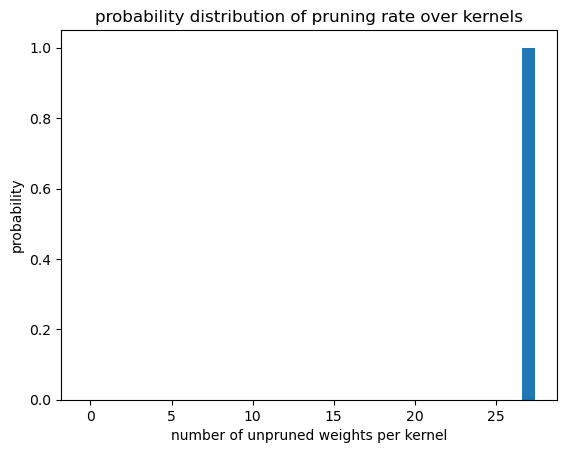

---------------------------------
 random sparse net statistics: 
---------------------------------
The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.234375 0.28125  0.453125]
  [0.359375 0.328125 0.359375]
  [0.375    0.265625 0.390625]]

 [[0.328125 0.3125   0.25    ]
  [0.25     0.203125 0.34375 ]
  [0.28125  0.40625  0.328125]]

 [[0.296875 0.296875 0.1875  ]
  [0.328125 0.25     0.296875]
  [0.390625 0.296875 0.375   ]]]
There are 259 positive weights and 283 negative weights. Therfore the sign ratio is 0.9151943462897526.


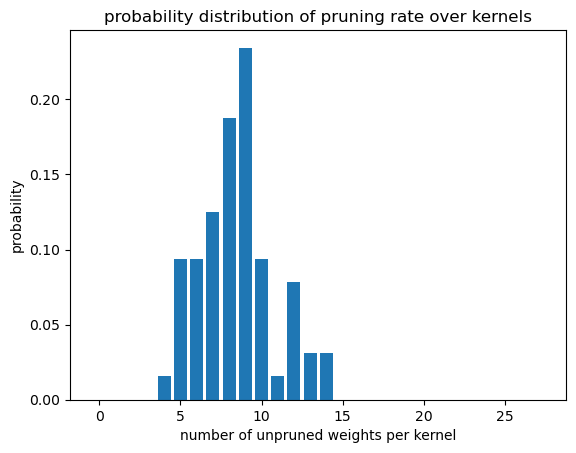

---------------------------------
 sign adapted net statistics: 
---------------------------------
The pruning rate is 0.3136574074074074, so 0.6863425925925926 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.328125 0.3125   0.296875]
  [0.375    0.265625 0.28125 ]
  [0.34375  0.328125 0.375   ]]

 [[0.359375 0.234375 0.28125 ]
  [0.34375  0.25     0.234375]
  [0.3125   0.328125 0.3125  ]]

 [[0.296875 0.375    0.375   ]
  [0.3125   0.3125   0.328125]
  [0.328125 0.203125 0.375   ]]]
There are 356 positive weights and 186 negative weights. Therfore the sign ratio is 1.913978494623656.


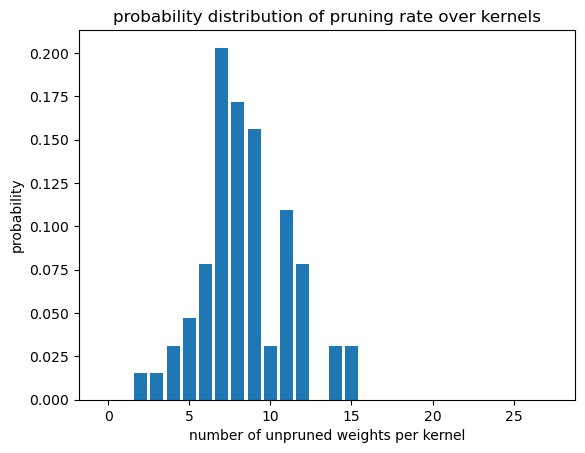

---------------------------------
 positionaly pruned net statistics: 
---------------------------------
The pruning rate is 0.3125, so 0.6875 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.28125  0.296875 0.296875]
  [0.3125   0.28125  0.3125  ]
  [0.3125   0.3125   0.34375 ]]

 [[0.3125   0.3125   0.359375]
  [0.296875 0.3125   0.328125]
  [0.3125   0.328125 0.34375 ]]

 [[0.28125  0.28125  0.328125]
  [0.328125 0.3125   0.328125]
  [0.296875 0.3125   0.3125  ]]]
There are 283 positive weights and 257 negative weights. Therfore the sign ratio is 1.1011673151750974.


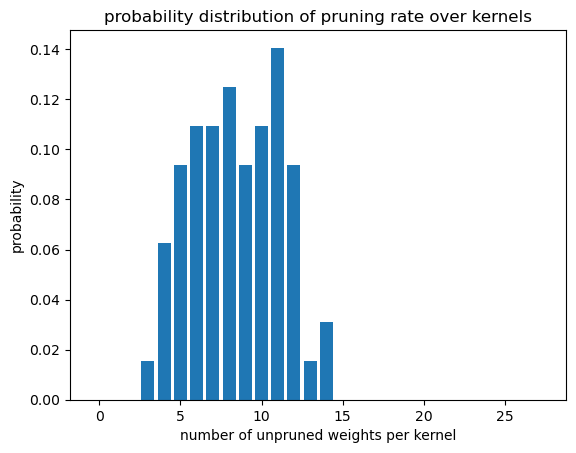

---------------------------------
 weight distribution pruned net statistics: 
---------------------------------
The pruning rate is 0.09837962962962964, so 0.9016203703703703 of the weights have been set to zero.
The probabilites for each position in the kernel to be unpruned: 
 [[[0.015625 0.140625 0.09375 ]
  [0.109375 0.078125 0.078125]
  [0.078125 0.109375 0.09375 ]]

 [[0.078125 0.125    0.078125]
  [0.0625   0.109375 0.125   ]
  [0.078125 0.140625 0.1875  ]]

 [[0.078125 0.078125 0.171875]
  [0.0625   0.0625   0.109375]
  [0.109375 0.109375 0.09375 ]]]
There are 89 positive weights and 81 negative weights. Therfore the sign ratio is 1.0987654320987654.


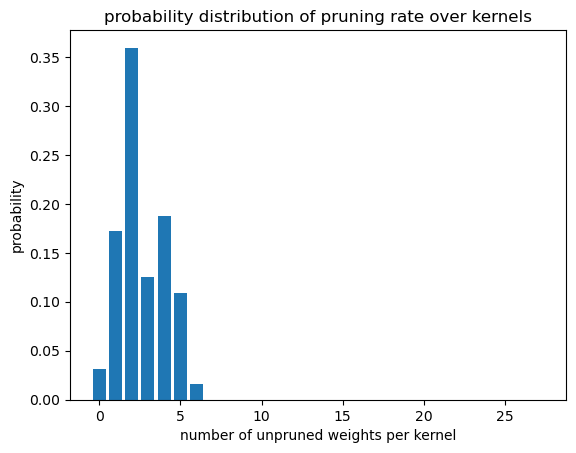

In [11]:
# Testing functions for implementing structural features of winning tickets

# initialize a model randomly
train_dataset, test_dataset = load_and_prep_cifar(batch_size=60, shuffle_size=512)
model = CNN2Model()
model(list(train_dataset)[0][0])

# get statistics of random not-sparse net
print("---------------------------------\n unpruned net statistics: \n---------------------------------")
unpruned_kernels = get_conv1_weights(model)
up_pruning_rate = get_pruning_rate(unpruned_kernels)
up_pos_probs = get_pos_probs(unpruned_kernels)
up_sign_ratio = get_sign_ratio(unpruned_kernels)
up_weight_distr = get_weight_distr(unpruned_kernels)

# get statistics of random sparse net
print("---------------------------------\n random sparse net statistics: \n---------------------------------")
pruned_kernels = random_pruning(unpruned_kernels, wt_pruning_rate)
rs_pruning_rate = get_pruning_rate(pruned_kernels)
rs_pos_probs = get_pos_probs(pruned_kernels)
rs_sign_ratio = get_sign_ratio(pruned_kernels)
rs_weight_distr = get_weight_distr(pruned_kernels)

# implementing wt sign ratio
print("---------------------------------\n sign adapted net statistics: \n---------------------------------")
pruned_kernels = random_pruning(unpruned_kernels, wt_pruning_rate)
sign_adapted_kernels = sign_ratio_adaption(pruned_kernels, wt_sign_ratio)
sa_pruning_rate = get_pruning_rate(sign_adapted_kernels)
sa_pos_probs = get_pos_probs(sign_adapted_kernels)
sa_sign_ratio = get_sign_ratio(sign_adapted_kernels)
sa_weight_distr = get_weight_distr(sign_adapted_kernels)

# implementing wt positional probabilities
print("---------------------------------\n positionaly pruned net statistics: \n---------------------------------")
pos_pruned_kernels = pos_prob_pruning(unpruned_kernels, wt_pos_probs)
pp_pruning_rate = get_pruning_rate(pos_pruned_kernels)
pp_pos_probs = get_pos_probs(pos_pruned_kernels)
pp_sign_ratio = get_sign_ratio(pos_pruned_kernels)
pp_weight_distr = get_weight_distr(pos_pruned_kernels)

# implementing wt weight distribution
print("---------------------------------\n weight distribution pruned net statistics: \n---------------------------------")
weight_distr_pruned_kernels = weight_distr_pruning(unpruned_kernels, wt_weight_distr)
wdp_pruning_rate = get_pruning_rate(weight_distr_pruned_kernels)
wdp_pos_probs = get_pos_probs(weight_distr_pruned_kernels)
wdp_sign_ratio = get_sign_ratio(weight_distr_pruned_kernels)
wdp_weight_distr = get_weight_distr(weight_distr_pruned_kernels)